In [1]:
import pandas as pd
import numpy as np
import nba_api.stats.endpoints as nba
import nba_api.stats.static.players as players
import nba_api.stats.static.teams as teams
import networkx as nx
import os

In [2]:
df = pd.read_csv('data/active_player_info_team.csv')
df

,index,id,Full_name,Firstname,Surname,Active,team_name,team_id
0,0,1630173,Precious Achiuwa,Precious,Achiuwa,True,Knicks,1610612752
1,1,203500,Steven Adams,Steven,Adams,True,Rockets,1610612745
2,2,1628389,Bam Adebayo,Bam,Adebayo,True,Heat,1610612748
3,3,1630534,Ochai Agbaji,Ochai,Agbaji,True,Raptors,1610612761
4,4,1631231,James Akinjo,James,Akinjo,True,NaN,0
...,...,...,...,...,...,...,...,...
610,610,203469,Cody Zeller,Cody,Zeller,True,Hawks,1610612737
611,611,1627826,Ivica Zubac,Ivica,Zubac,True,Clippers,1610612746
612,612,1641783,Tristan da Silva,Tristan,da Silva,True,Magic,1610612753
613,613,1628427,Vlatko Čančar,Vlatko,Čančar,True,Nuggets,1610612743


In [3]:
players_without_team = df[df['team_id'] == 0]
players_without_team.shape

(47, 8)

In [4]:
team_ids = df['team_id'].unique()
team_network = pd.DataFrame()
for team_id in team_ids:
    players_on_team = df[df['team_id'] == team_id]['id']
    for player_id in players_on_team:
        player_network = pd.DataFrame(columns=['passer_id', 'receiver_id', 'freq', 'team_id'])
        passes_made = nba.playerdashptpass.PlayerDashPtPass(team_id=team_id, player_id=player_id).get_data_frames()[0]
        player_network['receiver_id'] = passes_made['PASS_TEAMMATE_PLAYER_ID']
        player_network['freq'] = passes_made['FREQUENCY']
        player_network['passer_id'] = player_id
        player_network['team_id'] = team_id
        team_network = pd.concat([team_network, player_network], ignore_index=True)
    break


In [5]:
team_network

,passer_id,receiver_id,freq,team_id
0,1628384,1642278,0.008,1610612752
1,1628384,1630579,0.032,1610612752
2,1628384,1630574,0.005,1610612752
3,1628384,1630540,0.072,1610612752
4,1628384,1630346,0.003,1610612752
...,...,...,...,...
118,1626157,1628973,0.384,1610612752
119,1626157,1628969,0.114,1610612752
120,1626157,1628404,0.199,1610612752
121,1626157,1628384,0.105,1610612752


In [6]:
nba.playerdashptpass.PlayerDashPtPass(team_id=team_id, player_id=player_id).get_data_frames()[0]

,PLAYER_ID,PLAYER_NAME_LAST_FIRST,TEAM_NAME,TEAM_ID,TEAM_ABBREVIATION,PASS_TYPE,G,PASS_TO,PASS_TEAMMATE_PLAYER_ID,FREQUENCY,...,AST,FGM,FGA,FG_PCT,FG2M,FG2A,FG2_PCT,FG3M,FG3A,FG3_PCT
0,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Dadiet, Pacôme",1642359,0.004,...,0,0,1,0.000,0,1,0.000,0,0,0.000
1,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Kolek, Tyler",1642278,0.007,...,0,0,0,0.000,0,0,0.000,0,0,0.000
2,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"McBride, Miles",1630540,0.100,...,1,3,11,0.273,2,4,0.500,1,7,0.143
3,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Ryan, Matt",1630346,0.004,...,0,0,1,0.000,0,1,0.000,0,0,0.000
4,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Brunson, Jalen",1628973,0.384,...,8,14,35,0.400,13,29,0.448,1,6,0.167
5,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Bridges, Mikal",1628969,0.114,...,10,11,16,0.688,6,7,0.857,5,9,0.556
6,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Hart, Josh",1628404,0.199,...,3,4,14,0.286,3,9,0.333,1,5,0.200
7,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Anunoby, OG",1628384,0.105,...,12,15,28,0.536,14,21,0.667,1,7,0.143
8,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Payne, Cameron",1626166,0.083,...,2,2,8,0.250,0,3,0.000,2,5,0.400


In [ ]:
lastNGames = 10
LeagueID = '00'
Month = 1
OpponentTeamID = 0
PerMode = 'Totals'
PlayerID = '2544' #LeBron James
Season = '2019-20'
SeasonType = 'Regular Season'
TeamID = '1610612747'


lebron_made = nba.playerdashptpass.PlayerDashPtPass(team_id=TeamID, player_id=PlayerID).get_data_frames()[0]
lebron_received = nba.playerdashptpass.PlayerDashPtPass(team_id=TeamID, player_id=PlayerID).get_data_frames()[1]

In [ ]:
lebron_made

,PLAYER_ID,PLAYER_NAME_LAST_FIRST,TEAM_NAME,TEAM_ID,TEAM_ABBREVIATION,PASS_TYPE,G,PASS_TO,PASS_TEAMMATE_PLAYER_ID,FREQUENCY,...,AST,FGM,FGA,FG_PCT,FG2M,FG2A,FG2_PCT,FG3M,FG3A,FG3_PCT
0,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,10,"James, Bronny",1642355,0.003,...,0,0,1,0.000,0,0,0.000,0,1,0.000
1,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,10,"Knecht, Dalton",1642261,0.066,...,4,4,14,0.286,2,5,0.400,2,9,0.222
2,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,10,"Koloko, Christian",1631132,0.002,...,0,0,0,0.000,0,0,0.000,0,0,0.000
3,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,10,"Christie, Max",1631108,0.028,...,1,1,8,0.125,0,3,0.000,1,5,0.200
4,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,10,"Reaves, Austin",1630559,0.260,...,19,22,46,0.478,13,19,0.684,9,27,0.333
5,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,10,"Hayes, Jaxson",1629637,0.068,...,10,11,19,0.579,11,19,0.579,0,0,0.000
6,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,10,"Reddish, Cam",1629629,0.024,...,4,4,5,0.800,3,4,0.750,1,1,1.000
7,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,10,"Vincent, Gabe",1629216,0.061,...,3,4,15,0.267,2,6,0.333,2,9,0.222
8,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,10,"Hachimura, Rui",1629060,0.087,...,9,10,27,0.370,5,16,0.313,5,11,0.455
9,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,10,"Russell, D'Angelo",1626156,0.183,...,6,9,31,0.290,5,15,0.333,4,16,0.250


In [6]:
passing_stats_df = pd.read_csv('data/NBA_pass_data_2324_totals_regularseason.csv')

In [5]:
G = nx.DiGraph()
G.add_node('GOAL', attr='Goal')

In [7]:
for index, row in passing_stats_df.iterrows():
    player = row['PLAYER_NAME_LAST_FIRST']
    team = row['TEAM_NAME']
    if not G.has_node(player):
        G.add_node(player, attr=team)

In [8]:
for index, row in passing_stats_df.iterrows():
    goal_weight = 0
    edge = (str(row['PLAYER_NAME_LAST_FIRST']) + ' ' + str(row['TEAM_NAME']), str(row['PASS_TO']) + ' ' + str(row['TEAM_NAME']))
    weight = row['PASS']
    if G.has_edge(*edge):
        # If the edge exists, add to the current weight
        G[edge[0]][edge[1]]['weight'] += weight    
    else:
        G.add_edge(edge[0], edge[1], weight=weight)

    goal_weight = 2 * row['FG2M'] + 3 * row['FG3M']
    if goal_weight != 0:
        goal_edge = (str(row['PLAYER_NAME_LAST_FIRST']) + ' ' + str(row['TEAM_NAME']), 'GOAL')
        G.add_edge(goal_edge[0], goal_edge[1], weight=goal_weight)

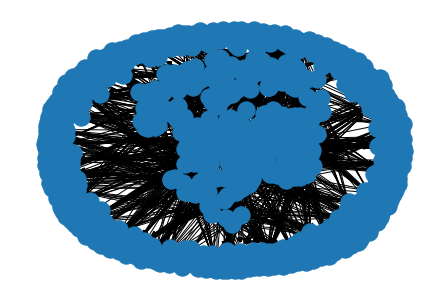

In [9]:
nx.draw(G)

In [ ]:
print(G.number_of_nodes())
print(G.number_of_edges())

In [10]:
team_players_df = pd.read_csv('data/team_player_23_24.csv')

In [ ]:
team_to_players = team_players_df.groupby('Team_ID')['Player_ID'].apply(set).to_dict()

# Step 2: Filter passing_stats_df for same-team passes
same_team_passes = passing_stats_df[
    passing_stats_df.apply(
        lambda row: row['PASS_TEAMMATE_PLAYER_ID'] in team_to_players.get(row['TEAM_ID'], set()),
        axis=1
    )
]

# Step 3: Initialize the graph
G = nx.DiGraph()

# Add nodes and edges for passes
for index, row in same_team_passes.iterrows():
    # Create unique node names for players
    passer = f"{row['PLAYER_NAME_LAST_FIRST']} {row['TEAM_NAME']}"
    receiver = f"{row['PASS_TO']} {row['TEAM_NAME']}"
    
    # Add nodes for passer and receiver
    if not G.has_node(passer):
        G.add_node(passer, team=row['TEAM_NAME'])
    if not G.has_node(receiver):
        G.add_node(receiver, team=row['TEAM_NAME'])
    
    # Add an edge for the pass
    edge = (passer, receiver)
    weight = row['PASS']
    if G.has_edge(*edge):
        # If edge exists, update the weight
        G[edge[0]][edge[1]]['weight'] += weight
    else:
        # Create a new edge
        G.add_edge(edge[0], edge[1], weight=weight)

# Add "GOAL" node and edges for made shots
for index, row in same_team_passes.iterrows():
    player = f"{row['PLAYER_NAME_LAST_FIRST']} {row['TEAM_NAME']}"
    goal_weight = 2 * row['FG2M'] + 3 * row['FG3M']
    
    if goal_weight > 0:
        goal_edge = (player, 'GOAL')
        if not G.has_node('GOAL'):
            G.add_node('GOAL')  # Add "GOAL" node if not already present
        if G.has_edge(*goal_edge):
            # Update goal edge weight
            G[goal_edge[0]][goal_edge[1]]['weight'] += goal_weight
        else:
            # Add new goal edge
            G.add_edge(goal_edge[0], goal_edge[1], weight=goal_weight)

# Step 4: Output the graph
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

folder_name = "Graphs"

# Check if the folder exists; if not, create it
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Define the file path
file_path = os.path.join(folder_name, "team_pass_graph" + ".gexf")

if not os.path.exists(file_path):
    nx.write_gexf(G, file_path)

Number of nodes: 523
Number of edges: 7521


In [ ]:
team_graphs = {}

# Step 1: Create a mapping of TEAM_ID to PLAYER_IDs
team_to_players = team_players_df.groupby('Team_ID')['Player_ID'].apply(set).to_dict()

# Step 2: Filter passes for same-team players
same_team_passes = passing_stats_df[
    passing_stats_df.apply(
        lambda row: row['PASS_TEAMMATE_PLAYER_ID'] in team_to_players.get(row['TEAM_ID'], set()),
        axis=1
    )
]

# Step 3: Process data for each team
for team_id, players in team_to_players.items():
    # Filter passes for the current team
    team_passes = same_team_passes[same_team_passes['TEAM_ID'] == team_id]
    
    # Initialize a directed graph for the team
    G = nx.DiGraph()

    # Add nodes and edges for passes
    for index, row in team_passes.iterrows():
        # Create unique node names for players
        passer = f"{row['PLAYER_NAME_LAST_FIRST']} {row['TEAM_NAME']}"
        receiver = f"{row['PASS_TO']} {row['TEAM_NAME']}"

        # Add nodes for passer and receiver
        if not G.has_node(passer):
            G.add_node(passer, team=row['TEAM_NAME'])
        if not G.has_node(receiver):
            G.add_node(receiver, team=row['TEAM_NAME'])

        # Add an edge for the pass
        edge = (passer, receiver)
        weight = row['PASS']
        if G.has_edge(*edge):
            # If edge exists, update the weight
            G[edge[0]][edge[1]]['weight'] += weight
        else:
            # Create a new edge
            G.add_edge(edge[0], edge[1], weight=weight)

    # Add "GOAL" node and edges for made shots
    for index, row in team_passes.iterrows():
        player = f"{row['PLAYER_NAME_LAST_FIRST']} {row['TEAM_NAME']}"
        goal_weight = 2 * row['FG2M'] + 3 * row['FG3M']

        if goal_weight > 0:
            goal_edge = (player, 'GOAL')
            if not G.has_node('GOAL'):
                G.add_node('GOAL')  # Add "GOAL" node if not already present
            if G.has_edge(*goal_edge):
                # Update goal edge weight
                G[goal_edge[0]][goal_edge[1]]['weight'] += goal_weight
            else:
                # Add new goal edge
                G.add_edge(goal_edge[0], goal_edge[1], weight=goal_weight)

    # Save the team graph
    team_name = team_passes['TEAM_NAME'].iloc[0] if not team_passes.empty else f"Team_{team_id}"
    team_graphs[team_name] = G

# Output results
for team_name, graph in team_graphs.items():
    print(f"Graph for {team_name}:")
    print(f"  Nodes: {len(graph.nodes)}")
    print(f"  Edges: {len(graph.edges)}")
    print("-" * 40)
    folder_name = "Graphs"

    # Check if the folder exists; if not, create it
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Define the file path
    file_path = os.path.join(folder_name, team_name + ".gexf")

    # Write the graph to the file in GEXF format
    nx.write_gexf(graph, file_path)